In [7]:
# 1. Importando as bilbiotecas de interesse
from fenics import *
import numpy as np
import os
import shutil
import time
import matplotlib.pyplot as plt

# 1.1. Importando as propriedades
from propriedades_5CAC import *
from utils import *
print(f'| Bibliotecas importadas com sucesso!')
print('----------------------------------------')
# 2. Definição do nome do caso
case_name = 'real_case_01'
print(f'| Rodando o caso: "{case_name}"...')


# 3. Criação da pasta de resultados do caso
dir_saida, dir_local = criar_pasta(case_name)
print('|--- Pasta criada com sucesso!')

# 4. Criação dos backups
# 4.1. Backup da Simulação
shutil.copy(dir_local + '/Fake Simulation.ipynb',
            dir_saida + '/backup_' + case_name + '.ipynb')
# 4.2. Backup das Propriedades
shutil.copy(dir_local + '/propriedades_5CAC.py',
            dir_saida + '/backup_propriedades.py')
print('|--- Back-up criado com sucesso!')

# 5. Criação da malha
def criar_malha():
    '''

    '''
    
    lx = 1
    ly = 3
    nx = 10
    ny = 30
    malha = RectangleMesh(Point(0, 0), Point(lx, ly), nx, ny)
    
    flags = MeshFunction('size_t', malha, malha.topology().dim() - 1)
    flags.set_all(0)

    class top(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], ly, 1e-2)


    class bottom(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 0, 1e-2)

 
    class left(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0, 1e-2)


    class right(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], lx, 1e-2)

    top = top()
    bottom = bottom()
    left = left()
    right = right()
    
    top.mark(flags, 1)
    bottom.mark(flags, 2)
    left.mark(flags, 3)
    right.mark(flags, 4)

    print('|--- Malha criada com sucesso!')
    return malha, flags

malha, flags = criar_malha()

| Bibliotecas importadas com sucesso!
----------------------------------------
| Rodando o caso: "real_case_01"...
|--- Pasta criada com sucesso!
|--- Back-up criado com sucesso!
|--- Malha criada com sucesso!


In [8]:
# 6. Criação dos espaços de funções
V = FunctionSpace(malha, 'CG', 1)
ds = Measure("ds", domain=malha, subdomain_data=flags)
T = Function(V)
phi = TrialFunction(V)

print('|--- Espaço de Funcões criado com sucesso!')

# 7. Definição das condições iniciais
t = 0
dt = 5  # passo de tempo [s]
t_rampa = 20 * 60
t_patamar = 10 * 60

T_0 =  25  # Temperatura de inicio do domínio [°C]
T_n = interpolate(Constant(T_0), V)

|--- Espaço de Funcões criado com sucesso!


In [9]:
# 8. Definição das condições de contorno
BC_array = np.load('Dir_BC_HF_EX001.npz')
t_DC = BC_array['t']
T_2_DC = BC_array['T_2']
def curva_de_aq(t):
    T_D_val = np.interp(t / 60, t_DC, T_2_DC)

    return T_D_val

T_D = Expression('T_D_t', degree=2, T_D_t=curva_de_aq(t))

cond_dirich = []
def aplicar_Dirichlet(T_D, flag):
    cond_dirich.append(DirichletBC(V, T_D, flags, 1))
    cond_dirich.append(DirichletBC(V, T_D, flags, 3))
    
    print('|--- Condição de Contorno de Dirichlet aplicada com sucesso!')

aplicar_Dirichlet(T_D, flags)
# Vai aparecer diretamente no problema matemático
# def aplicar_Neumann(q_N, flag):
#     print('|--- Condição de Contorno de Neumann aplicada com sucesso!')

T_M = 23  # Temperatura do ambiente em [°C]
h = 10 # Coeficiente de película em [W/m2 K]


# 9. Definir o problema matemático
def criar_problema():
    # 9.1. Definição do Resíduo
    ResT = rho(T_n) * Cp(T_n) * ((T - T_n) / dt) * phi * dx
    ResT += lmbda(T_n) * inner(nabla_grad(T), nabla_grad(phi)) * dx

    # 9.2. Condições de Contorno de Neumann
    ResT += (h * (T - T_M)) * phi * (ds(2))
    ResT += (h * (T - T_M)) * phi * (ds(4))

    
    Jac = derivative(ResT, T)
    problema = NonlinearVariationalProblem(ResT, T,
                                      cond_dirich, Jac)
    print('|--- Problema criado com sucesso!')
    return problema
    
problema = criar_problema()
# 8. Definir o solver para resolver o problema matemático
def criar_solver(problema):
    non_lin_solver = NonlinearVariationalSolver(problema)
    prm = non_lin_solver.parameters
    prm["newton_solver"]["absolute_tolerance"] = 1E-6
    prm["newton_solver"]["relative_tolerance"] = 1E-13
    prm["newton_solver"]["maximum_iterations"] = 10
    prm['newton_solver']['error_on_nonconvergence'] = True

    # Set FEniCS log level
    set_log_level(50)
    print('|--- Solver criado com sucesso!')
    return non_lin_solver

solver = criar_solver(problema)
# 9. Definir Funções para salvar os dados

# Files for saving the fields
filex = XDMFFile(dir_saida + '/Fields.xdmf')
filex.parameters['functions_share_mesh'] = True
filex.parameters['rewrite_function_mesh'] = False
filex.parameters["flush_output"] = True

T_RAM = []
def escrever_na_RAM(T):
    T_RAM.append(T.copy(deepcopy=True))
    print('Dados armazenados na RAM com sucesso!')

def escrever_no_disco(T, t):
    filex.write(T, t)
    print('Dados salvos com sucesso!')

# 10. Loop temporal
t_f = 1 * 3600  # tempo final da simulação [s]
# Opção 1 - Usando loop com for
# nt = int(t_f / dt)
# for i in range(nt):
#     t = t + dt


# Opção 2 - Usando loop com while
print('|--- Começando o loop com sucesso(?)')

while t <= t_f:
    print(f'|------ t = {t} s   | {t / (t_f) * 100:.4} % Completo')
    T_D.T_D_t = curva_de_aq(t)
    print(f'|------ T_D = {T_D.T_D_t:.4} °C')
    solver.solve()
    T_n.vector()[:] = T.vector()
    escrever_no_disco(T, t)
    escrever_na_RAM(T)
    t = t + dt

T_RAM_nodes = np.array([T_i.vector()[:] for T_i in T_RAM])
np.savez(dir_saida + '/valores_nodais', T_nodes=T_RAM_nodes)
print('Simulação terminada com sucesso!')

|--- Condição de Contorno de Dirichlet aplicada com sucesso!
|--- Problema criado com sucesso!
|--- Solver criado com sucesso!
|--- Começando o loop com sucesso(?)
|------ t = 0 s   | 0.0 % Completo
|------ T_D = 21.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 5 s   | 0.1389 % Completo
|------ T_D = 21.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 10 s   | 0.2778 % Completo
|------ T_D = 21.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 15 s   | 0.4167 % Completo
|------ T_D = 21.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 20 s   | 0.5556 % Completo
|------ T_D = 21.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 25 s   | 0.6944 % Completo
|------ T_D = 21.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 30 s   | 0.8333 % Completo
|------ T_D = 21.8 °C
Dados salvos com sucesso!
Dado

|------ T_D = 260.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1300 s   | 36.11 % Completo
|------ T_D = 261.0 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1305 s   | 36.25 % Completo
|------ T_D = 261.4 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1310 s   | 36.39 % Completo
|------ T_D = 261.8 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1315 s   | 36.53 % Completo
|------ T_D = 262.3 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1320 s   | 36.67 % Completo
|------ T_D = 262.7 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1325 s   | 36.81 % Completo
|------ T_D = 263.1 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1330 s   | 36.94 % Completo
|------ T_D = 263.5 °C
Dados salvos com sucesso!
Dados armazenados na RAM com sucesso!
|------ t = 1335 s   | 3

Simulação terminada com sucesso!


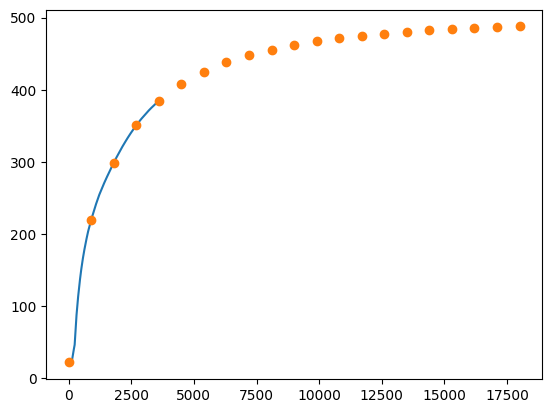

In [11]:
ts = np.linspace(0, 1, 721) * 3600
plt.plot(ts, [T(0, 1.5) for T in T_RAM])
plt.plot(t_DC * 60, T_2_DC, 'o', markevery=15)

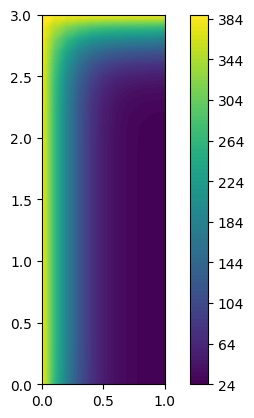

In [5]:
plt.tricontourf(malha.coordinates()[:, 0],
                malha.coordinates()[:, 1],
                malha.cells(),
                T.compute_vertex_values(), levels=100)

plt.colorbar()
plt.gca().set_aspect('equal')

plt.show()

In [51]:
T_RAM = np.load('./resultados/real_case_01/valores_nodais.npz')['T_RAM']

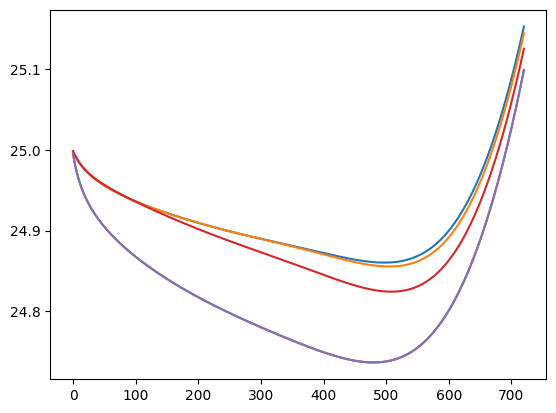

In [87]:
# plt.plot([T(0, 1.5) for T in T_RAM])
plt.plot([T(1, 1.5) for T in T_RAM])
plt.plot([T(1, 0.5) for T in T_RAM])
plt.plot([T(1, 0) for T in T_RAM])
plt.plot([T(1, 0.25) for T in T_RAM])
plt.plot([T(1, 0) for T in T_RAM])


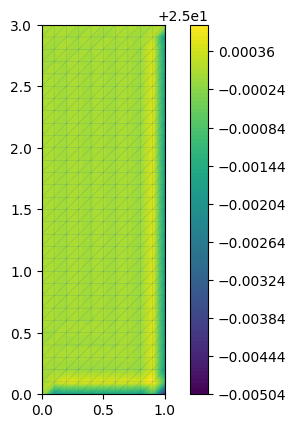

In [70]:
plt.tricontourf(malha.coordinates()[:, 0],
                malha.coordinates()[:, 1],
                malha.cells(),
                T_RAM[0], levels=100)
plt.triplot(malha.coordinates()[:, 0],
                malha.coordinates()[:, 1],
                malha.cells(), lw=0.1)
plt.colorbar()
plt.gca().set_aspect('equal')

plt.show()

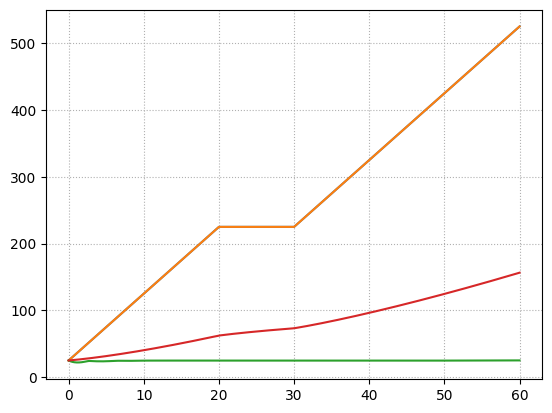

In [65]:
ts = np.linspace(0, 1, 721) * 3600
plt.plot(ts/60, [curva_de_aq(t) for t in ts])

plt.plot(ts/60, T_RAM.max(axis=1))
plt.plot(ts/60, T_RAM.min(axis=1))
plt.plot(ts/60, T_RAM.mean(axis=1))


plt.grid(ls=':')
plt.show()

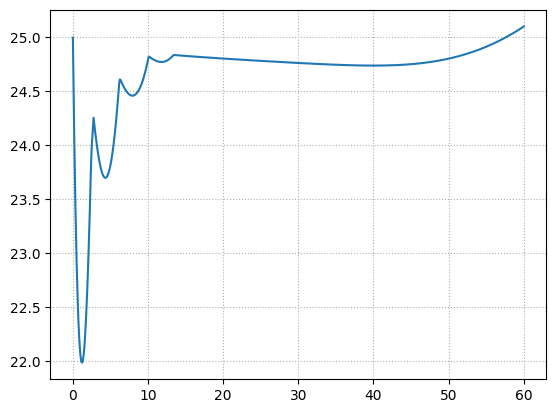

In [66]:
ts = np.linspace(0, 1, 721) * 3600
plt.plot(ts/60, T_RAM.min(axis=1))


plt.grid(ls=':')
plt.show()